# Project: Behavior Cloning

This project is about training a car on simulator to run in autonomous mode in a way which is considered safe.

##   The goals / steps of this project are the following:

1. Use the simulator to collect data of good driving behavior.
2. Build, a convolution neural network in Keras that predicts steering angles from images.
3. Train and validate the model with a training and validation set.
4. Test that the model successfully drives around track one without leaving the road.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras.models import Sequential
from keras.layers import Convolution2D, ELU, Flatten, Dropout, Dense, Lambda, MaxPooling2D
from keras.preprocessing.image import img_to_array, load_img
import csv

%matplotlib inline
data_dir_path = "data"


Using TensorFlow backend.


# Data Collection
To collect data, I drove the car on simulator for 3 laps and collected its data .Additionally to train on the sharp curve(just before second mud portion) better, I drove and collected data of this area 3 more times.

In all, It gave me set of 6038 images, each from centre camera, left camera and right camera.

In [12]:
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
        
print("Number of DataSets: ",len(lines))



Number of DataSets:  6038


# Data Augmentation

To train model better at curves, perticularly, at sharp curves, I augmented data, such that all the data entries which have steering angle greater then a threshold(in my case 0.15), then add that entry twice more to data.This is done to give more weightage to data which have sharp angles. 

This prevented me from collecting more data by training vehicle near curvy area.

In [13]:
non_zero_angles = []

angle_threshold = 0.15
for line in lines:
    steering_angle = float(line[3])
    if abs(steering_angle) > angle_threshold:
        non_zero_angles.append(line)

print("Number of datasets having steering_angle greater than threshold:", len(non_zero_angles))

for non_zero_angle in non_zero_angles:
    for i in range(2):
        lines.append(non_zero_angle)

print("Total Number of datasets:", len(lines))    

Number of datasets having steering_angle greater than threshold: 1158
Total Number of datasets: 8354


# Split for Training and Validation

I split the collected data between training and validation data in ration 80:20. For this I used sklearn's train_test_split function   

In [14]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

# Image Augmentation and Preprocessing
 For a sample number provided, I randomly select a image from centre camera, left camera or right camera. If the image is selected from left or right camera, then adjusted the steering angle by adding/subtracting offset.
 
I further augmented this image augmenting brightness. Then I cropped the image so that only relevent lower half of the image remains. I then resized this image to 64X64. 


In [15]:
def augment_brightness(image):
    # convert to HSV 
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    # Brightness reduction factor
    random_bright = .25+np.random.uniform()

    # Apply the brightness reduction 
    image1[:,:,2] = image1[:,:,2]*random_bright

    # convert to RBG again
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def crop_image(image):
    cropped_image = image[60:140,:,:]
    return cropped_image

def resize_image(image):
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    return image


def get_augmented_image(samples,image_num,visualize = 'False',augmentImage = 'False'):
    ADJUSTMENT_OFFSET = 0.25
    typeOfImg = np.random.randint(3)
    #print("typeOfImg is : ",typeOfImg)
    
    
    line = samples[image_num]
    
    if typeOfImg == 0:
                img_path =  'data/IMG/' + line[0].split('/')[-1]
                org_image = mpimg.imread(img_path) 
                steer_angle = float(line[3]) 
    elif typeOfImg == 1:
                img_path =  'data/IMG/' + line[1].split('/')[-1]
                org_image = mpimg.imread(img_path)   
                steer_angle =  float(line[3]) + ADJUSTMENT_OFFSET
    elif typeOfImg == 2:
                img_path =  'data/IMG/' + line[2].split('/')[-1]
                
                org_image = mpimg.imread(img_path) 
                steer_angle = float(line[3]) - ADJUSTMENT_OFFSET
   
    if augmentImage == 'True':
        # Randomly Flip the image
        flip_prob = np.random.random()
        #print("Flip prob is: ",flip_prob )
        if flip_prob > 0.5:
            # flip the image and reverse the steering angle
            steer_angle = -1*steer_angle
            image = cv2.flip(org_image, 1)
        else:
            image = org_image
        
        #  Augment Brightness
        image = augment_brightness(image)
    else:
        image = org_image
        
    
    #crop image 
    image = crop_image(image)
    image = resize_image(image)
    if visualize == 'True':
        # Plot the examples
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(org_image)
        plt.title('Original Image')
        plt.subplot(122)
        plt.imshow(image)
        plt.title('Processed Image')
    
    #Normalize image
    image = image/255.0 - 0.5
    return image,steer_angle
    
   
    
    

# Examples of Image Augmentation and Preprocessing

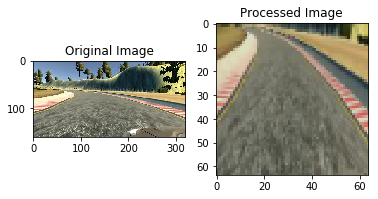

In [17]:
image,steerang = get_augmented_image(lines,18,visualize = 'True',augmentImage= 'True')

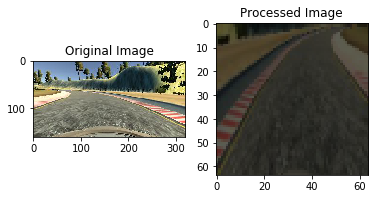

In [18]:
image,steerang = get_augmented_image(lines,23,visualize = 'True',augmentImage= 'True')

In [19]:
from sklearn.utils import shuffle
def data_generator(samples, sample_type="TRAINING", batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for sample_counter in range(len(batch_samples)):
                augment_prob = np.random.random()
                #print("augment prob is: ",augment_prob )
                if sample_type == "TRAINING" and (augment_prob > 0.5):
                    image,steer_angle = get_augmented_image(batch_samples,sample_counter,visualize = 'False',augmentImage = 'True')
                else:
                    image,steer_angle = get_augmented_image(batch_samples,sample_counter,visualize = 'False',augmentImage = 'False')

                images.append(image)
                angles.append(steer_angle)

            yield shuffle(np.array(images), np.array(angles))

# Model Architecture

I used the architecture suggested by NVIDIA in [research paper](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) 

In the model, I used 5 layers. I also added Dropout layer after each layer to avoid over fitting. To provide non-linearity I used ELU layer after each Convolution2D layer. I tried using RELU layer instead of ELU layer, but there is no noticeable difference. 

The model used adam optimizer with loss being calculated using mean squared error.

The model summary is printed below:




In [20]:
def get_model():
    model = Sequential()

    # layer 1 output shape is 32x32x32
    model.add(Convolution2D(32, 5, 5, input_shape=(64, 64, 3), subsample=(2, 2), border_mode="same"))
    model.add(ELU())

    # layer 2 output shape is 15x15x16
    model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(.4))
    model.add(MaxPooling2D((2, 2), border_mode='valid'))

    # layer 3 output shape is 12x12x16
    model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(.4))

    # Flatten the output
    model.add(Flatten())

    # layer 4
    model.add(Dense(1024))
    model.add(Dropout(.3))
    model.add(ELU())

    # layer 5
    model.add(Dense(512))
    model.add(ELU())

    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

    

# Tuning Parameters
I used batch size of 256. I initially trained model for 10 epochs but noticed that after 7 epochs the training loss and validation loss stabilizes. So I trained my final model for only 7 epochs.

In [11]:
BATCH_SIZE = 256
num_of_samples = len(train_samples)
num_samples_per_epoch = (num_of_samples//BATCH_SIZE)*(BATCH_SIZE-1)

train_generator = data_generator(train_samples,sample_type="TRAINING", batch_size=256)
valid_generator = data_generator(validation_samples,sample_type="VALIDATION", batch_size=256)
model = get_model()
model.summary()

model.fit_generator(train_generator, samples_per_epoch=num_samples_per_epoch, nb_epoch=7, 
                    validation_data = valid_generator, nb_val_samples=1000)

print("Saving model weights and configuration file.")

model.save('model.h5')  # always save your weights after training or during training
with open('model.json', 'w') as outfile:
     outfile.write(model.to_json())
        
print("Model Saved")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    2432        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 32, 32, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 30, 30, 16)    4624        elu_1[0][0]                      
____________________________________________________________________________________________________
elu_2 (ELU)                      (None, 30, 30, 16)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

/Users/arunt/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6656/6630 [==============================] - 93s - loss: 1.4348 - val_loss: 0.1205
Epoch 2/7
6683/6630 [==============================] - 80s - loss: 0.1134 - val_loss: 0.0688

# Output Video
The output video is at [link](https://youtu.be/LAyODPjcwMA). I captured the output for 2 laps.

# Reflection

The project gave a very interesting insight in application of deep learning. The car is smooth in video , though at sharp turns it sometimes go in danger area. By by and large , It remains on right track. 